**CLASIFICACIÓN DE SONIDOS MEDIANTE UNA RED NEURONAL CONVOLUCIONAL UTILIZANDO ESPECTROGRAMAS DEL CONJUNTO DE DATOS URBANSOUND8K**

****Wilhelm David Buitrago Garcia****

Estudiante de pregrado en Ingeneria Mecatrónica,
Universidad Nacional de Colombia sede de La Paz

Proyecto final de la asignatura: Redes Neuronales y aprendizaje profundo

6 de octubre de 2023



In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.0 MB/s eta 0:00:00


In [ ]:
#Importe de librerias necesarias
import librosa #Libreria para manejo de audio y señales
import librosa.display #Libreria para graficar señales
import matplotlib.pyplot as plt #Libreria para graficación de datos
import os #Libreria para manipular el sistema o entorno de trabajo
import numpy as np #Libreria matematica
import pandas as pd #Libreria para manejo de CSV y DataFrames
from resampy import resample
import torch #Redes neuronales, funcones, etc...
import torch.nn as nn #Moduel
import torch.nn.functional as F #Funciones de activacion
import torchvision.datasets as dset #Database
import torchvision.transforms as transforms #Tranformaciones del Databasse
import torch.optim as optim #Optimizador
from torch.utils.data import DataLoader,Dataset #Cargador de Datasets
from sklearn.metrics import ConfusionMatrixDisplay, classification_report #Librerias para comprobar la red
from sklearn.model_selection import train_test_split #Libreria para crear train y test loaders
import shutil #Libreria para manejo de carpetas
from tqdm.notebook import tqdm #Visualizacion

Este conjunto de datos contiene 8732 extractos de sonido (en formato wav) etiquetados (<=4 s) de sonidos urbanos de 10 clases: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music.

Presenta 10 carpetas donde se encuentran mezclados diferentes sonidos correspondientes a distintas clases, de igual forma presente un CSV donde contienen informacion como: Nombre del archivo, fsID, segundo de comienzo del audio, segundo de finalizacion del audio, salience, en que carpeta de encuentra (1-10), que clase categorica representa (0-9), y la clase en string

In [ ]:
proyecto_dir = '/content/ProyectoFinal'
if os.path.exists(proyecto_dir):
    shutil.rmtree(proyecto_dir)  # Elimina la carpeta y su contenido
!git clone https://github.com/WilhelmBuitrago/ProyectoFinal.git #Cargamos el Dataset (este proceso puede ser un poco tardado)

Cloning into 'ProyectoFinal'...
remote: Enumerating objects: 8765, done.
remote: Counting objects: 100% (842/842), done.
remote: Compressing objects: 100% (841/841), done.
remote: Total 8765 (delta 0), reused 841 (delta 0), pack-reused 7923
Receiving objects: 100% (8765/8765), 5.60 GiB | 35.29 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (8733/8733), done.


In [ ]:
directorio = os.getcwd() #Obteneos la ruta del directorio actual
fulldataset = directorio + "/ProyectoFinal/Proyecto"
metadata = pd.read_csv(fulldataset + "/UrbanSound8K.csv") #Acedemos al CSV del Dataset
metadata.head(10)
#Este CSV contienen los nombre de archivos, en que carpeta se encuentran y su label
print(metadata.classID.value_counts())

3    1000
2    1000
0    1000
9    1000
5    1000
7    1000
4    1000
8     929
1     429
6     374
Name: classID, dtype: int64


In [ ]:
def extract_f(audio,sample_rate):
    mels = librosa.feature.melspectrogram(y=audio, sr=sample_rate) #Se hace un espectograma de poder MFCCS teniendo en cuenta el audio y su sample rate
    spec = librosa.power_to_db(mels) #Transformamos los datos de poder a decibeles
    return spec

def read_ad(file_name):
    audio, sample_rate = librosa.load(file_name) #Cargamos y separamos un archivo de audio en su informacion y su sample rate
    return audio, sample_rate

def reshapespec(featureslist):
    f = []
    f1 = []
    desired_shape = (128, 176) #Tamaño que tendran todas las imagenes
    for i in range(len(featureslist)):
        mel_spectrogram_padded = np.zeros(desired_shape) #Se crea una matris de ceros del tamaño que deben tener las imagenes
        mel_spectrogram_padded[:, :featureslist[i][0].shape[1]] = featureslist[i][0] #Se rellena la matriz con la informacion del espectrograma hasta donde llegue la informacion, lo dema seraá cero
        l = featureslist[i][1]
        n = mel_spectrogram_padded.reshape(1,mel_spectrogram_padded.shape[0],mel_spectrogram_padded.shape[1]) #Hacemos un reshape para que sea compatible con la entrada del modelo
        n = torch.Tensor(np.array(n,dtype=np.float32)) #El audio se tranforma a tipo de dato float32 y a Tensor
        f.append([n,l])
    featuresdfmod = pd.DataFrame(f,columns=['features','class_label']) #Se crea un DataFrame que en la primera columan correspondera al espectrograma (todos tienen la misma dimension) y la segunda a su label correspondiente
    return featuresdfmod

In [ ]:
features = []
val = []
for index,row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldataset),'fold'+str(row["fold"])+'/',str(row["slice_file_name"])) #Obtenemos la ruta de un archivo del CSV del dataset
    class_label = row["classID"] #Obtenemos el label de ese archivo
    audi, sample_rate = read_ad(file_name) #Cargamos el audio
    data = extract_f(audi, sample_rate) #Tranformamo el audio a espectogramas de decibeles
    data = torch.Tensor(np.array(data,dtype=np.float32))
    if row["fold"] == 1: #Utilizamos la carpeta 1 para la validacion del modelo
        val.append([data,class_label])
    else: #Las carpetas respetantes seran para entrenamiento y testeo del modelo
        features.append([data,class_label])

#Hacemos el reshape a todos los espectogramas
featuresmod = reshapespec(features)
valmod = reshapespec(val)
#featuresdf = pd.DataFrame(features,columns=['features','class_label'])
#valdf = pd.DataFrame(val,columns=['features','class_label'])


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


7859
873


In [ ]:
print("Porcentaje de entramiento y testeo: {:0.0f}%".format((len(featuresmod)/8732)*100))
print("Porcentaje de validacion: {:0.0f}%".format((len(valmod)/8732)*100))

Porcentaje de entramiento y testeo: 90%
Porcentaje de validacion: 10%


In [ ]:
#Para utilizar DataLoader, el DataFrame debe tener una forma tal que pueda llamar objeto de la forma: Dataset[indx]
#Por tanto se configura el Dataset para que esto pueda suceder
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.Tensor(self.data.iloc[idx, 0])  # Suponiendo que la primera columna contiene tus datos
        label = torch.Tensor([self.data.iloc[idx, 1]])   # Suponiendo que la segunda columna contiene las etiquetas
        return features, label

dataset = CustomDataset(featuresmod) #Objeto Dataset del entrenamiento y testeo
valset = CustomDataset(valmod) #Objeto del Dataset de la validacion
train, test = train_test_split(dataset, test_size = 0.4) #Dividimos los datos de entreamiento en un 60% y los de test en un 40%
batchsize = 32
train_loader = DataLoader(train,batch_size=batchsize,shuffle=True) #Creamos un dataloader de entramiento con un numero de batch 32 y mezclado
val_loader = DataLoader(valset,batch_size=batchsize,shuffle=False) #Creamos un dataloader de validacion con un numero de batch 32 y sin mezclar

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Obtenemos el entorno de trabajo (CPU o GPU)
#Creacion de red neuronal
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Ingresa un batch de (1,128,176) y sale junto con el max_pool2d(24,64,88)
        self.conv1 =  nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride=1,padding=2)
        #Ingresa un batch de (24,64,88) y sale junto con el max_pool2d(48,32,44)
        self.conv2 =  nn.Conv2d(in_channels= 24, out_channels=48, kernel_size=5,stride=1, padding=2)
        #Ingresa un batch de (48,32,44) y sale junto con el max_pool2d(48,16,22)
        self.conv3 =  nn.Conv2d(in_channels= 48, out_channels=48, kernel_size=5,stride=1, padding=2)


        #Aplanamos los datos de salida para una red lineal
        self.out1 = nn.Linear(48*16*22, 512)
        #Ultima capa lineal con 10 neuronas de salida (10 clases)
        self.out2 = nn.Linear(512, 10)


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2) #Stride de 2
        x = F.max_pool2d(F.relu(self.conv2(x)),2) #Stride de 2
        x = F.max_pool2d(F.relu(self.conv3(x)),2) #Stride de 2
        x = x.view(x.size(0), -1)  #Aplanamos los datos (48*16*22)
        x =  F.relu(self.out1(x)) #Activacion ReLU
        output =  F.softmax(self.out2(x),dim=1) # Función de activación softmax en la salida de la capa de salida
        return output

In [ ]:
model = CNN().to(device) #Model contendra la red neuronal
criterion = nn.CrossEntropyLoss()  #Perdida de la entropía cruzada entre los valores de entrada y el target
optimizer = optim.Adam(model.parameters(), lr = 0.0001)  #Optimizador adam con un learning rate de 0.01(variar?)

In [ ]:
def entrenar_un_paso(batch):
    optimizer.zero_grad() #Los gradientes a cero
    data, labels = batch #El batch se divide en data (imagen) y labels (target)
    labels = labels.reshape(len(labels)) #Labels deben tener forma [#NumLabels,]
    labels = labels.to(torch.int64) #Labels debe ser de tipo int64
    data, labels = data.to(device), labels.to(device) #Pasamos los datos al device (cuda)
    preds = model.forward(data) #Forward a la imagen
    loss = criterion(preds, labels) #Calculo de perdida
    loss.backward() #Propagación hacia atras
    optimizer.step() #Actualizacion de pesos
    return loss.item() #Devolvemos la perdida
def validate(epoch,val_loss):
    path = '/content/checkpoint.pt' #Donde y con que nombre se guardara el modelo
    val_loss2,val_l = 0.0,0.0 #Los errores de validacion empiezan siendo cero
    for batch2 in val_loader:
      data, labels = batch2 #Separamos en data y labels el batch de validacion
      labels = labels.reshape(len(labels)) #Labels deben tener forma [#NumLabels,]
      labels = labels.to(torch.int64) #Labels debe ser de tipo int64
      data, labels = data.to(device), labels.to(device) #Pasamos los datos al device (cuda)
      preds = model.forward(data) #Forward a la imagen
      loss = criterion(preds, labels) #Calculo de perdida
      val_loss2 = loss.item() #Guardamos la perdida en una variable
      if val_loss2 < val_loss: #Verificamos si la perdida actual de validacion, es menor a la que se obtuvo cuando se realizo anteriormente
            val_loss2 = val_loss #Si se cumple la condicion anterior, se actualiza el valor de la perdida al valor actual
            torch.save(model.state_dict(),path) #Se guarda el modelo como mejor modelo en el path
      val_l += loss.item() #Obtemos la perdida
    return val_loss, val_l/len(val_loader.dataset) #Devolvemos la perdida de validacion, y la perdida promedio de validacion
def entrenar_una_epoca(epoch):
    train_loss = 0.0 #Errores de entramientos inializados en cero
    for batch in train_loader:
        train_loss += entrenar_un_paso(batch) #Se entrena un paso
    return train_loss/len(train_loader.dataset) #Se devuelve el error promedio

In [ ]:
max_epochs= 100 #Numero de pasos
running_loss = np.zeros(shape=(max_epochs, 1)) #Un arreglo para guardar el error promedio para su graficación
valloss = [] #Una lista donde guardaremos el error de validacion
val = np.inf #El error de validacion comienza siendo infinito
for epoch in tqdm(range(max_epochs)):
    running_loss[epoch] = entrenar_una_epoca(epoch) #Entrenamos la red y en cada paso guardamos la perdida promedio
    if epoch % 10 == 0: #Cada 10 epocas se realiza la validacion del modelo
      val, valp = validate(epoch,val)
      valloss.append(valp)
      print("Perdida promedio de validacion: {}".format(valp))
    print("Epoca: {}, Perdida Promedio de entrenamiento: {} ".format(epoch,running_loss[epoch,0]))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoca: 0, Perdida Promedio: 0.05875228955662263, 
Epoca: 1, Perdida Promedio: 0.05623311771441366, 
Epoca: 2, Perdida Promedio: 0.05469816744896412, 
Epoca: 3, Perdida Promedio: 0.053521176891387585, 
Epoca: 4, Perdida Promedio: 0.05298302059841055, 
Epoca: 5, Perdida Promedio: 0.052509121095894, 
Epoca: 6, Perdida Promedio: 0.052116820617546335, 
Epoca: 7, Perdida Promedio: 0.051877430185659816, 
Epoca: 8, Perdida Promedio: 0.05153006523815976, 
Epoca: 9, Perdida Promedio: 0.05157358115450069, 
Epoca: 10, Perdida Promedio: 0.05103764374713756, 
Epoca: 11, Perdida Promedio: 0.049780183986287606, 
Epoca: 12, Perdida Promedio: 0.04919571815846707, 
Epoca: 13, Perdida Promedio: 0.048549082448601344, 
Epoca: 14, Perdida Promedio: 0.048040374971270436, 
Epoca: 15, Perdida Promedio: 0.04778291258806894, 
Epoca: 16, Perdida Promedio: 0.04766374509129772, 
Epoca: 17, Perdida Promedio: 0.047479051244094544, 
Epoca: 18, Perdida Promedio: 0.04743897437037997, 
Epoca: 19, Perdida Promedio: 0.04733

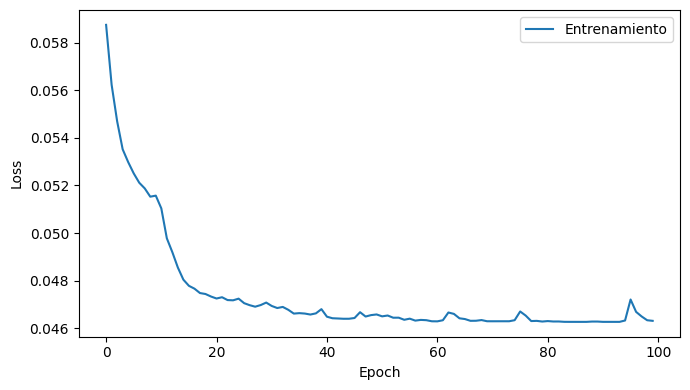

In [ ]:
#Grafica de la perdida de entrenamiento en 100 epocas
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

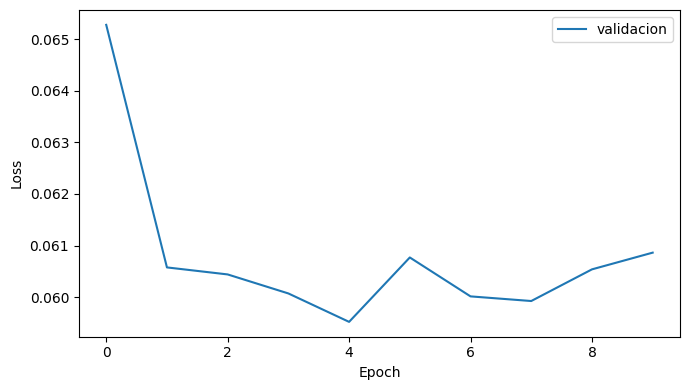

In [ ]:
#Grafica de perdida de validacion cada 10 epocas
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(valloss, label='validacion')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

In [ ]:
#Cargamos el mejor modelo
path =  "/content/checkpoint.pt"
model.load_state_dict(torch.load(path))

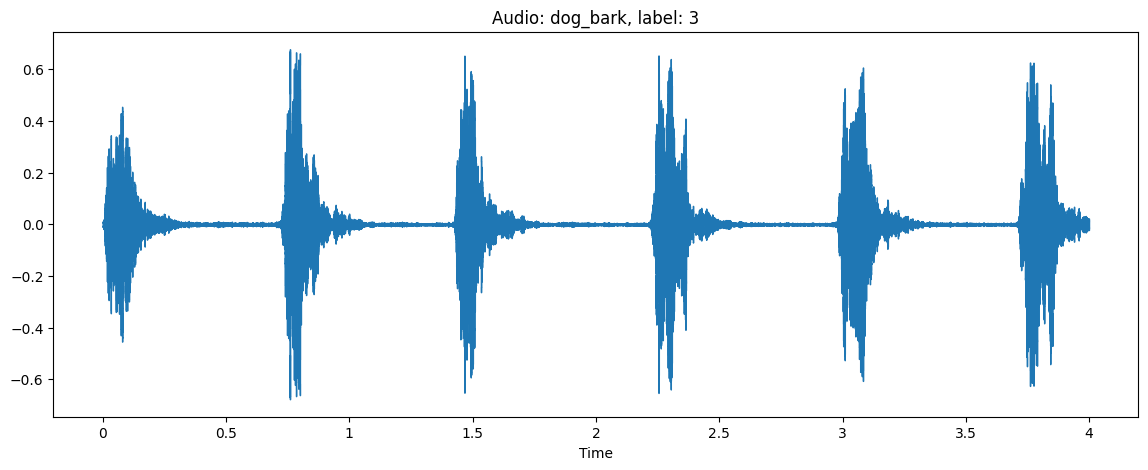

In [ ]:
#Prueba para un solo audio
indx = 20 #Indice dedl audio
#Cargamos el path del arhivo, su label verdadero y su clase
file_name = os.path.join(os.path.abspath(fulldataset),'fold'+str(np.array(metadata[metadata["slice_file_name"] == metadata.loc[indx][0]]['fold'])[0])+'/',str(np.array([metadata.loc[indx][0]])[0]))
t = str(np.array([metadata[metadata["slice_file_name"] == metadata.loc[indx][0]]['class']])[0][0])
l = str(np.array([metadata[metadata["slice_file_name"] == metadata.loc[indx][0]]['classID']])[0][0])
audio,sr = read_ad(file_name) #Cargamos el audio
#Visualizamos el audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.title('Audio: ' + t + ', label: ' + l);

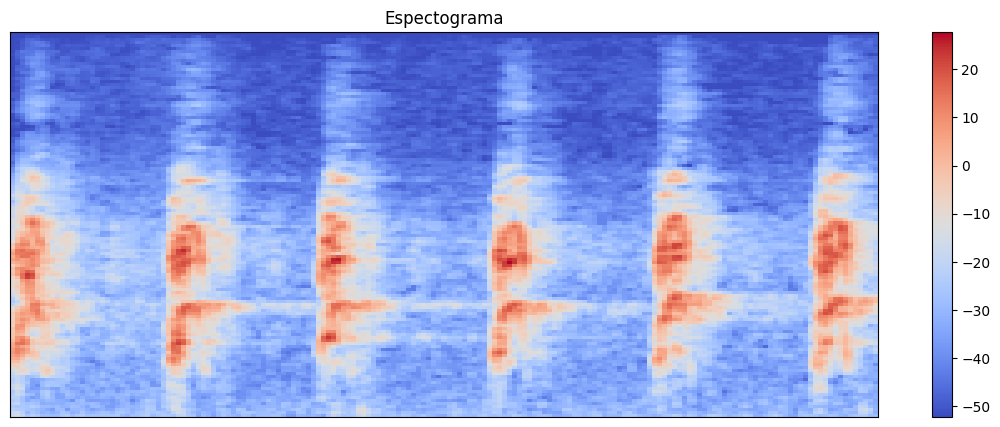

In [ ]:
#Extraemos el espectograma del audio
data = extract_f(audio, sr)
#Visualizamos el espectograma
plt.figure(figsize=(14, 5))
librosa.display.specshow(data)
plt.colorbar()
plt.title("Espectograma")
plt.show()

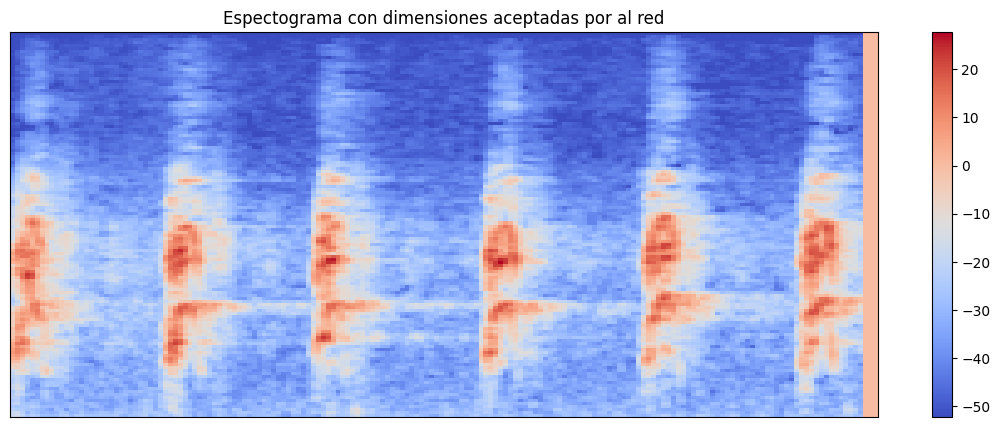

In [ ]:
#Tranformamos las dimensiones del espectogramas a las aceptadas por al red
f = []
f.append([data, np.array([metadata[metadata["slice_file_name"] == metadata.loc[indx][0]]['classID']])[0][0]])
data = reshapespec(f)
#Visualizamos la nueva forma del espectograma
plt.figure(figsize=(14, 5))
librosa.display.specshow(np.array(data.loc[0][0],dtype=np.float64).reshape(128,176))
plt.colorbar()
plt.title("Espectograma con dimensiones aceptadas por al red")
plt.show()

In [ ]:
#Creamos el dataset para ese archivo
datanew = CustomDataset(data)
datanewl = DataLoader(datanew,shuffle=False,batch_size=1)
#Evaluamos la red para el archivo de audio
for batch in datanewl:
  data, label = batch
data = data.to(device)
pred = model(data).to(device)
pred = pred.argmax(dim=1).detach().cpu().numpy()
#Imprimimos los resultados
print('Label real: ' + l)
print('Label Predicho: {}'.format(pred[0]))

Label real: 3
Label Predicho: 3


              precision    recall  f1-score   support

           0      0.950     0.929     0.939       351
           1      0.919     0.970     0.944       164
           2      0.840     0.847     0.844       366
           3      0.914     0.835     0.873       357
           4      0.907     0.907     0.907       354
           5      0.938     0.930     0.934       358
           6      0.940     0.986     0.962       143
           7      0.925     0.968     0.946       372
           8      0.924     0.962     0.943       343
           9      0.860     0.839     0.849       336

    accuracy                          0.910      3144
   macro avg      0.912     0.917     0.914      3144
weighted avg      0.910     0.910     0.909      3144



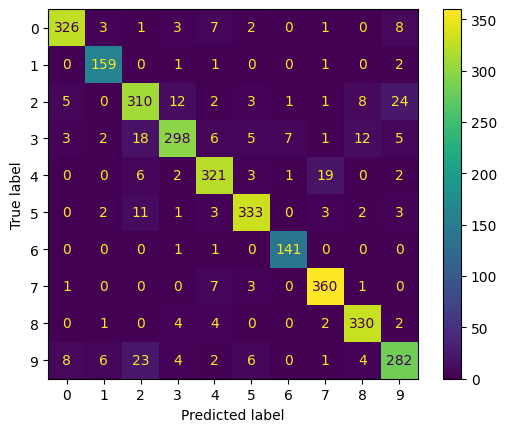

In [ ]:
#Verificacion del modelo
#Nuevo batch de verificacion
test_loader = DataLoader(test, shuffle=False, batch_size=100)
#Encontramos los targets verdaderos de todo el conjunto de testeo
test_targets = []  #Se inicializa los objetivos del test como una lista vacia
test_targets_pri = [] #Se inicializa otra lista vacia que contendra los objetivos del test
for batch in test_loader:
  x, y = batch  #Se igualan x,y a batch
  y = y.reshape(len(y))
  y = y.to(torch.int64)
  test_targets.append(y.numpy()) #Se le agrega los objetivos del dataset a la lista de los objetivos del test
for i in range(len(test_targets)):
  test_targets_pri.append(test_targets[i].tolist()) #Se crea una lista que agrega los objetivos como listas por batch
test_targets = np.array([item for lista in test_targets_pri for item in lista]) #Una lista que contiene todos los valores esperado de todo el dataset
#Utilizamos la red entrenada para predecir lo numeros del testeo y se guardan la predicciones
prediction_test = [] #Se inicializa la predicción del test como una lista vacia
for mbdata, label in test_loader:
    label = label.reshape(len(label))
    label = label.to(torch.int64)
    mbdata = mbdata.to(device) #Se ejecuta mbdata en la gpu
    logits = model(mbdata) #Se guarda la predicción del modelo de mbdata en la variable logits
    prediction_test.append(logits.argmax(dim=1).detach().cpu().numpy()) #Se trae logits de la gpu a la cpu, se convierte en un arreglo y se le aplica un argmax
prediction_test = np.concatenate(prediction_test) #Se concatena las predicciones del test

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
#Graficacion de aciertos
#Esta es una forma visual de representar los aciertos y predicciones mal realizadas de la red, se grafican los valores esperados respecto a los valores predichos
#La diagonal debe tener el mayor numero de aciertos para una buena presicion
ConfusionMatrixDisplay.from_predictions(test_targets, prediction_test)

print(classification_report(test_targets, prediction_test, digits=3))

Durante la implementación de la presente red neuronal para clasificar sonidos utilizando el dataset UrbanSound8k, se enfrento a varios desafíos significativos que influyeron en el diseño y el rendimiento del modelo.

Uno de los desafíos iniciales fue la conversión de sonidos a espectrogramas. Los espectrogramas son representaciones visuales de datos de audio que permiten a las redes neuronales trabajar con datos de sonido. Se obtuvieron problemas utilizando la libreria Librosa ya que "no realizaba los espectogramas correctamente", sucedia que en realidad, no se convitieron los espectogramas a decibeles, sino solo a poder.

Los espectrogramas pueden variar en dimensiones debido a diferencias en la duración de los sonidos en el dataset. Esto presentó un desafío en el diseño del modelo, ya que las redes neuronales convolucionales (CNN) requieren entradas de tamaño fijo. Para superar esto, se opto por rellenar los espectrogramas con ceros hasta alcanzar un tamaño deseado (128x176)

Otro desafío importante fue garantizar que los datos se cargaran correctamente en PyTorch. Esto incluyó la conversión de los espectrogramas y las etiquetas en formatos compatibles con PyTorch.

En conclusion, se obtuvo una red neuronal de tres capas convolucionales cada una con un MaxPooling, y dos capaz linealmente densas, el modelos mostró una precision de 90%, observando que el mejor modelo estuvo aproximadamente en la epoca 40.